In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting import hist
import seaborn as sns
import pandas as pd
import sys
import cPickle
from sklearn.linear_model import Ridge, Lasso

# The matplotlib inline special command must be commented out if you run this as 
# a script or on the ipython/python command line.
%matplotlib inline

In [2]:
# This sets the default appearance of seaborn and its colour palette
sns.set(style="white")
sns.set_palette('colorblind')

In [61]:
data = fetch_sdss_sspp()
# Extract some data. 
ug = data['upsf']-data['gpsf']
gr = data['gpsf']-data['rpsf']
ri = data['rpsf']-data['ipsf']
iz = data['ipsf']-data['zpsf']
T = data['Teff']

X = np.vstack((ug, gr, ri, iz, T)).T
M = np.vstack((ug, gr, ri, iz)).T

Seaborn works a lot better with Pandas data frames so we create one here and then print the first three rows in the table.

In [62]:
df = pd.DataFrame(X[0:1000, :], columns=['u-g', 'g-r', 'r-i', 'i-z', 'T'])

In [12]:
df[0:3]

,u-g,g-r,r-i,i-z,T
0,1.441999,0.614000,0.200999,0.113001,5480.200195
1,1.715000,0.685999,0.226999,0.121000,5166.100098
2,1.295000,0.505999,0.232000,0.098000,5573.200195


# Scatter plot matrices / scatter grid

These are convenient ways to plot x vs y for datasets with many relationships.

## Seaborn

In Seaborn the simplest function is called `pairplot`. It does quite a good job straight out of the box, so it is the go-to-function. You can control the appearance in various ways. 

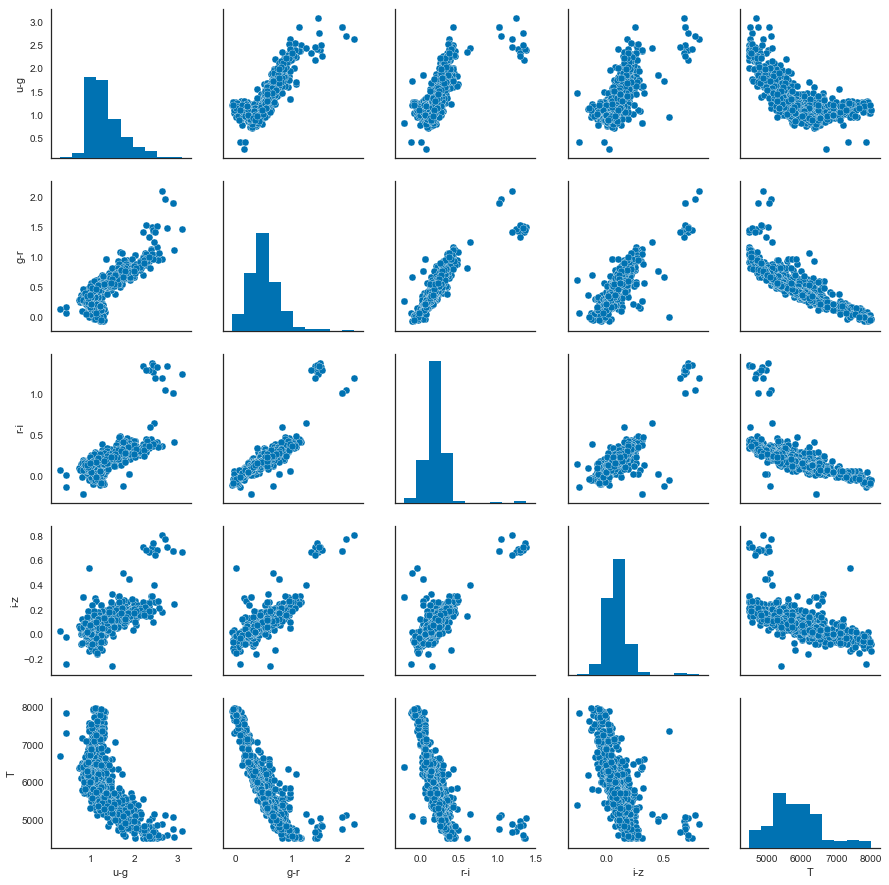

In [37]:
sns.pairplot(df)

Now this might look good to start with, but sometimes you might want other information included. You can control some of this with the `kind` argument. So to show the same, but doing a regression plot in each panel you add `kind='reg'`

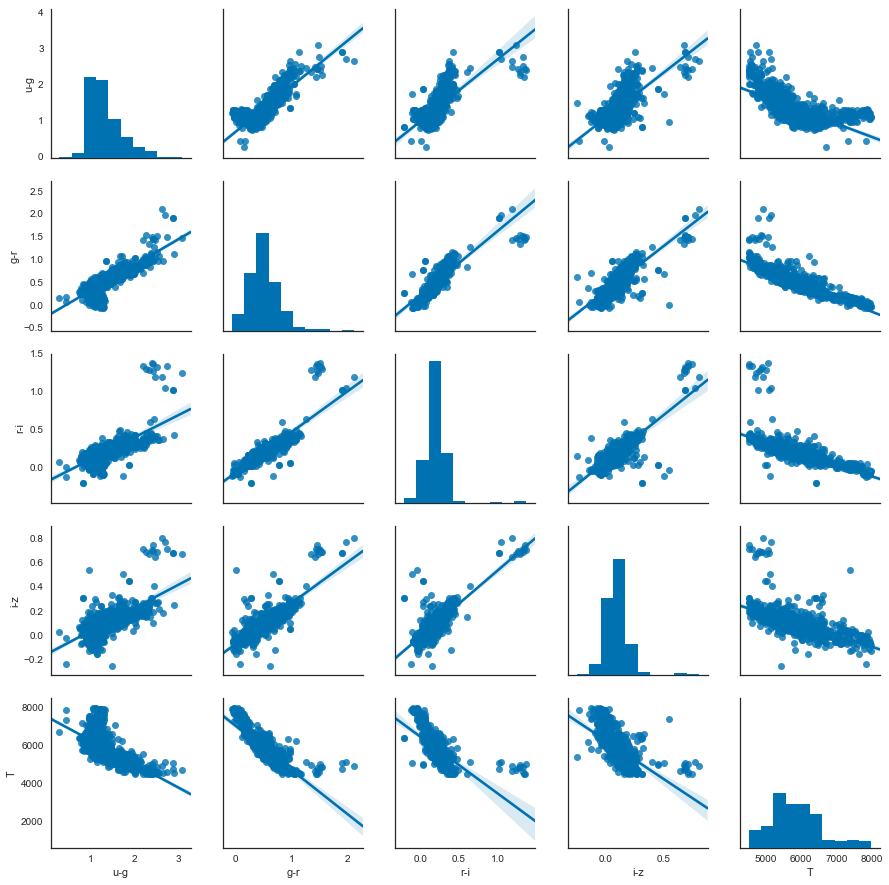

In [38]:
sns.pairplot(df, kind='reg')

However there are still issues here. One is that we get a lot of points on top of each other - we can therefore set the transparency and I would also like to colour the points based on some quantity - in particular the temperature. To do this we need to pass arguments to the plot command underlying `pairplot`. We do this using the `plot_kws` argument. This accepts a dictionary with the plot keywords as you would pass them to scatter.

So we want `alpha=0.3` to get partially transparent points, and I'll make them a bit smaller. Unfortunately, however, there is a "bug/feature" in `seaborn` which stops you from passing in a `c=df['T']` to colour your scatter plot so I will have to use PairGrid directly to do this - we'll do that next.

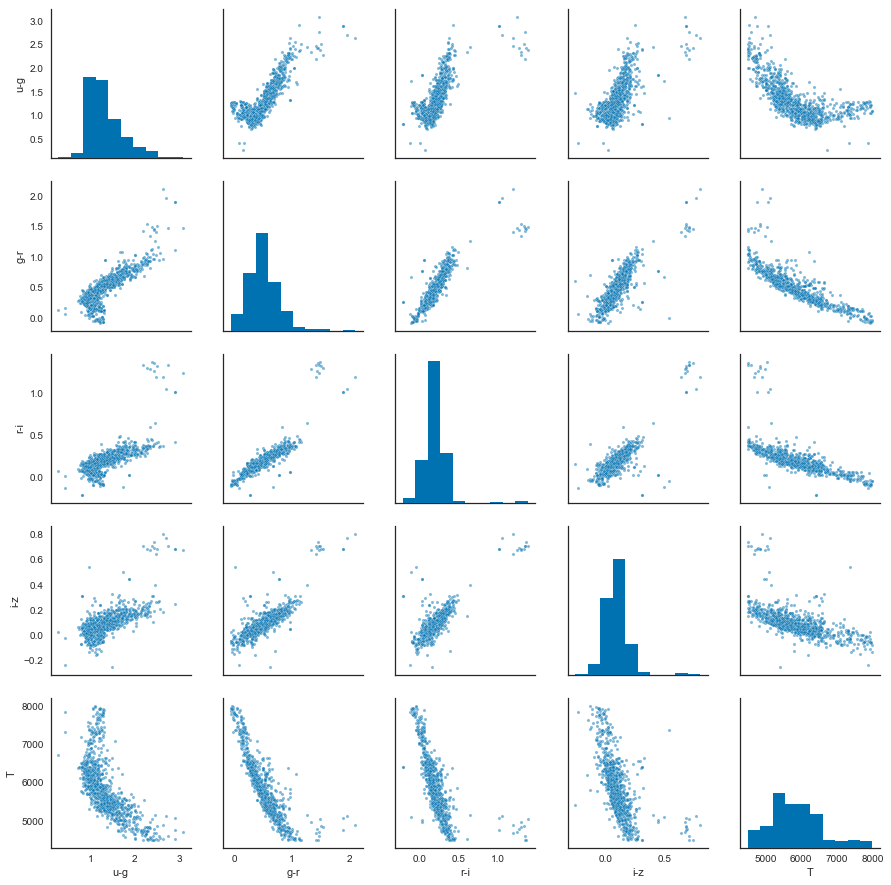

In [44]:
sns.pairplot(df, plot_kws=dict(alpha=0.5, s=10))

To create more complex pair plots you can call `PairGrid` directly - but just calling PairGrid gives you no useful plot

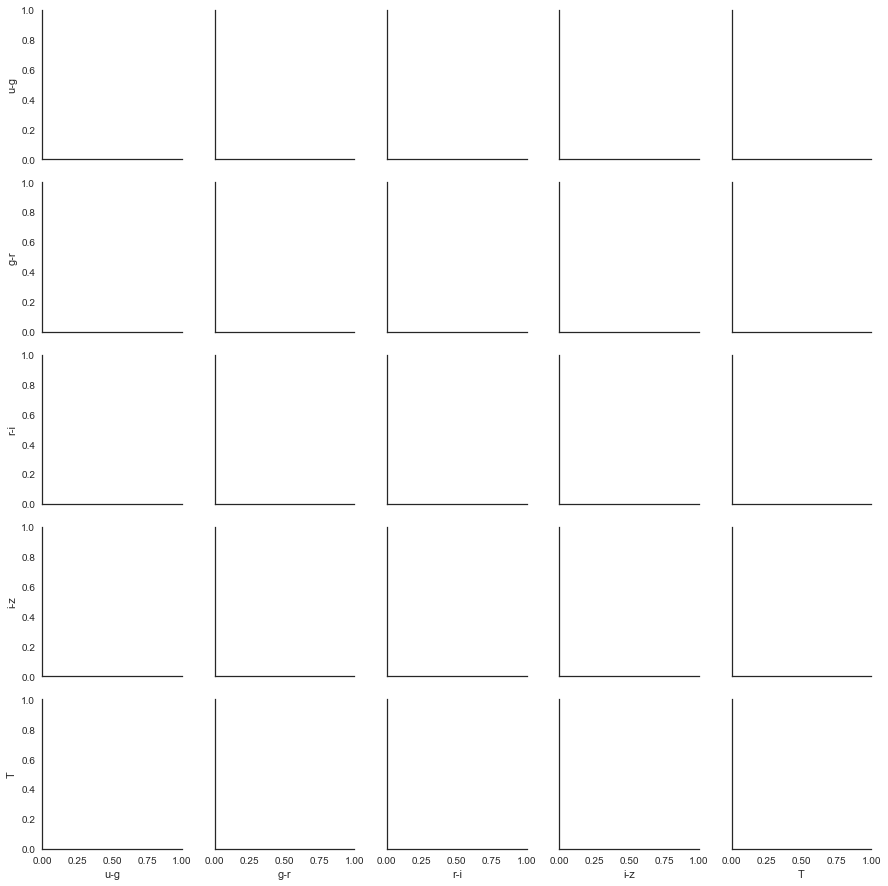

In [33]:
g = sns.PairGrid(df)

As you can see, the grid is completely empty! This is because we haven't gold the grid how to map data onto the grid. This might seem very annoying (and maybe it is), but it gives a lot of flexibility. To actually show the data you need to say how they are mapped onto the grid. The simplest is to use the `map` function which uses the same way to plot the data for each panel:

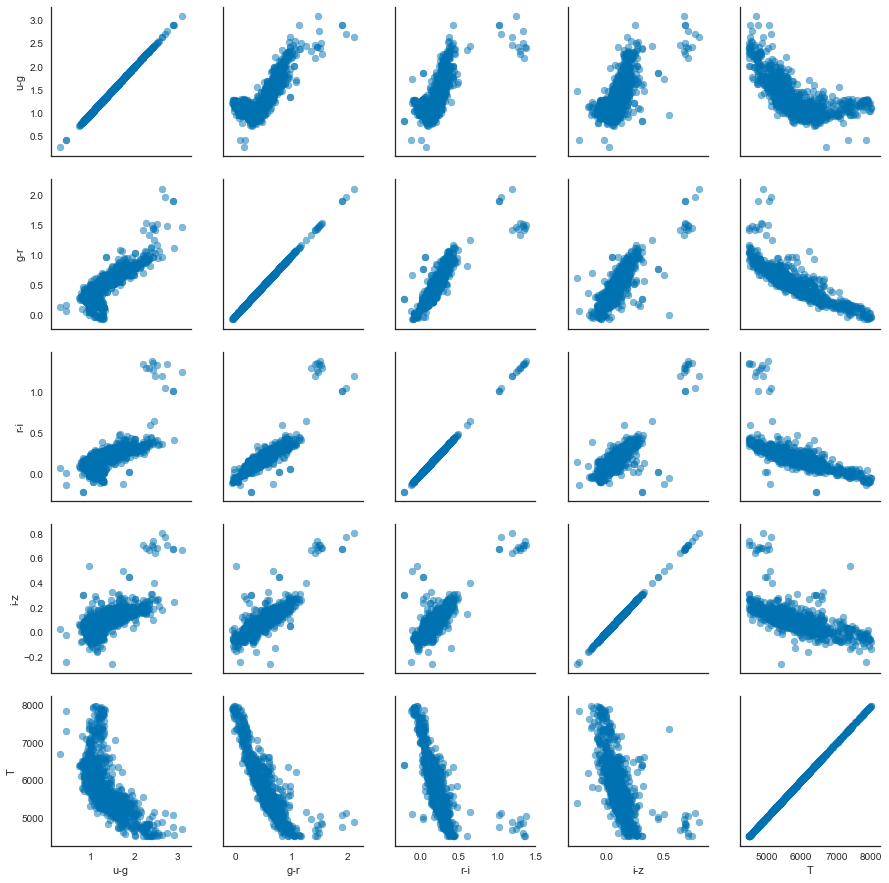

In [68]:
g = sns.PairGrid(df)
g.map(plt.scatter, alpha=0.5)

This was fine, but there is a lot of repetition and the diagonals are not useful. It is better to use the `map_diag` function to say what you want on the diagonal, and `map_upper` and `map_lower` for the plots above or below the diagonal (or `map.offdiag` to treat all off-diagonal entries equally. In addition I want to colour the points according to the temperature. To do this it is necessary to write a small wrapper - which I call `colplot` below. What you will notice is a problem with this plot is that there is no colour bar included. This is suboptimal!

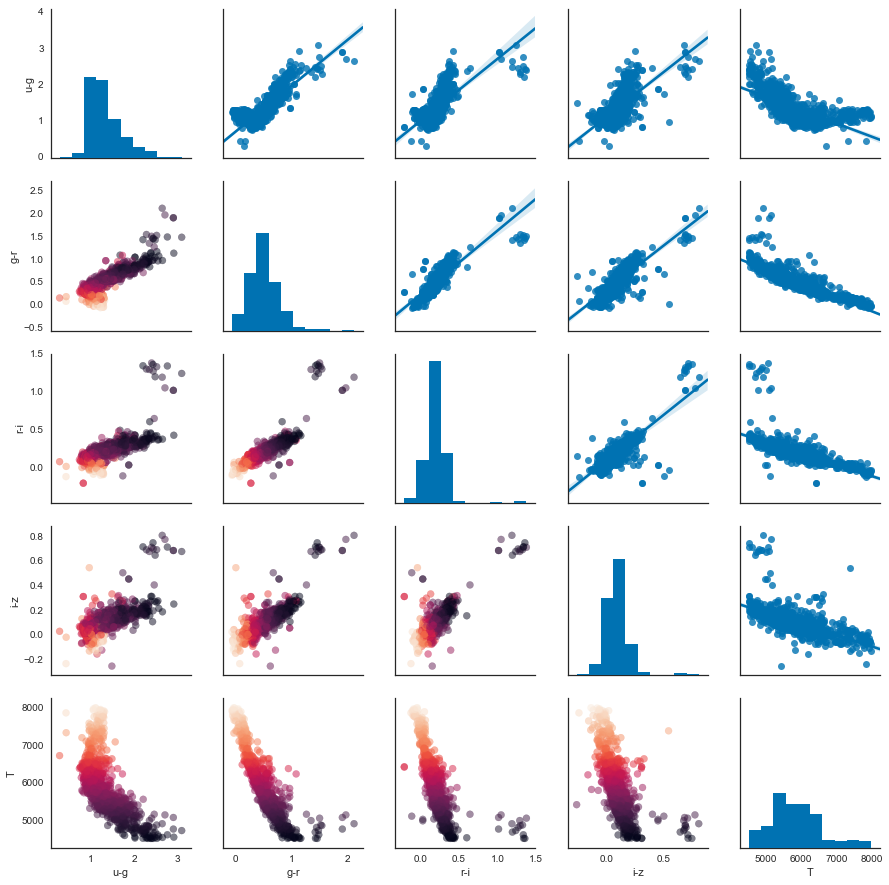

In [69]:
def colplot(x, y, color, **kwargs):
    plt.scatter(x, y, **kwargs)

g = sns.PairGrid(df)
g.map_diag(plt.hist)
g.map_lower(colplot, c=df['T'], marker='o', vmax=8000, vmin=4500, alpha=0.5)
g.map_upper(sns.regplot)

# 1-dimensional plots

Let us compare the distribution of u-g colour for stars with 5000K, 6000K, 7000K, 7500K with a range of 100K. The way to approach this with `matplotlib` and `seaborn` is a bit different. 

Let us first do `matplotlib`. In this case you want to create a list where each element in the list is the data for that temperature range.

In [74]:
# I put the central temperatures and DeltaT in a function so that we are sure to 
# use the same values in different functions
def Tc_DeltaT():
    Tc = [5000, 6000, 7000, 7500]
    DeltaT = 100
    
    return Tc, DeltaT
    
def make_mpl_data(df):
    """
    Create a list of u-g colors at different temperatures.
    """
    Tc, DeltaT = Tc_DeltaT()

    # To create the list we need to loop over the Tc values and then use the np.where
    # function to find the indices of the data in this range
    data_mpl = []
    labels = []
    for t in Tc:
        inside, = np.where(np.abs(df['T']-t) < DeltaT)

        data_mpl.append(df['u-g'][inside])
        labels.append("{0}<T<{1}".format(t-DeltaT, t+DeltaT))
        
    return data_mpl, labels

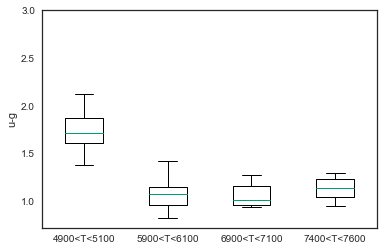

In [78]:
d_mpl, labels = make_mpl_data(df)

x_pos = [1, 2, 3, 4]
res = plt.boxplot(d_mpl)
tmp = plt.xticks(x_pos, labels, rotation='horizontal')
plt.ylabel('u-g')

Whether you like the preceding plot or not - the alternative of using histograms is not so nice:

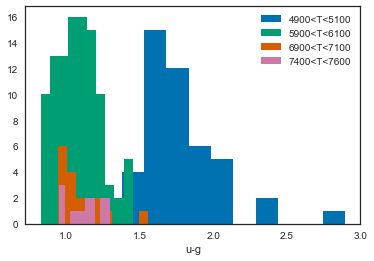

In [91]:
for d, label in zip(d_mpl, labels):
    hs = plt.hist(d, normed=False, label=label)
plt.xlabel('u-g')
plt.legend()

A Kernel density estimate of the distribution leads to a KDE plot - this is a bit nicer:

(0, 3)

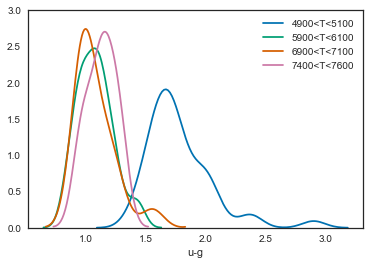

In [92]:
for d, label in zip(d_mpl, labels):
    sns.kdeplot(d, label=label)
plt.xlabel('u-g')
plt.ylim(0, 3)

But it is also possible to make a slightly nicer box plot using Pandas. To do that we need a slightly different approach. We need to create a dataframe where one column indicates which group that dataset belongs to. 

In [122]:
ug = np.hstack(d_mpl)
ug.shape
l = []
for i, d in enumerate(d_mpl):
    n = len(d)
    x = [labels[i] for count in range(n)]
    l.extend(x)
h = {'u-g': ug, 'label': l}
df_pd = pd.DataFrame({'u-g': ug, 'label': l})

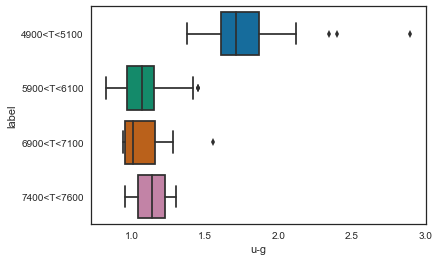

In [127]:
sns.boxplot(x='u-g', y='label', data=df_pd)